In [210]:
%matplotlib notebook
import matplotlib.pylab as plt

import numpy as np
import pandas as pd

import numpy as np
import importlib
import integralclient as ic
importlib.reload(ic)
ic.__file__

In [295]:
t0_utc="2020-04-28T14:34:33"
t1_rel_days=-1
t2_rel_days=1.5
source_name="SGR 1935+2154"

In [296]:
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
t=Simbad.query_object(source_name)
source_coord = SkyCoord(t[0]['RA'], t[0]['DEC'], unit=("hourangle", "deg"))
source_coord

<SkyCoord (ICRS): (ra, dec) in deg
    (293.732, 21.89672222)>

In [42]:
import astropy.io.fits as fits
from astropy import units as u
from astropy import constants as const


In [57]:
import importlib
import integralclient as ic

selecting timesystem endpoint https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem/
failed to import oda


In [317]:
import numpy as np

In [145]:
import hashlib

hashstring = lambda x:hashlib.sha224(x.encode()).hexdigest()[:8]

In [276]:
burst_0_utc = "2020-04-28T14:34:24.4"
burst_0_ijd = float(ic.converttime("UTC", burst_0_utc, "IJD"))

#t1,t2 = ic.converttime("IJD", burst_0_ijd - 1./24/3600, "UTC"),  ic.converttime("IJD", burst_0_ijd + 1./24/3600, "UTC"), 

scw=ic.converttime("IJD", burst_0_ijd, "SCWID")

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T14:34:24.4/IJD
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.608027592592407/SCWID


In [319]:
import yaml

bursts = yaml.load(open("draft/PAPER_SGR1935_INTEGRAL/data/burst-search/bursts.yaml"))

#for b in bursts[]

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


ConstructorError: while constructing a Python instance
expected a class, but found <class 'builtin_function_or_method'>
  in "draft/PAPER_SGR1935_INTEGRAL/data/burst-search/bursts.yaml", line 1791, column 16

In [229]:
import ddaclient

importlib.reload(ddaclient)

ddac = ddaclient.RemoteDDOSA("http://cdcihn/staging-1.2/ddosa-worker-osa11", 
                      "/mnt/sshfs/isdc-in01/unsaved_data/neronov/data/reduced/ddcache-private-staging-1.2/")

modules = ['git://ddosa',
           'git://findic/icversion', 
           'git://ddosa11/icversion-noisecontrol', 
           'git://gencat',
           'git://ddosa_delegate']


cat = ("SourceCatalog", 
           {
            "autoversion": True, 
            "catalog": [
                {"NAME":"SGR 1935+2154", "RA": 293.73200 , "DEC":  21.89672}
            ]
           }
      )


for burst in bursts:
    burst_0_ijd = burst['ijd']
    
    rs = {}
    burst['image_results']=rs
    
    for dt in 0.1, 0.5, 1, 3, 5, 8, 10, 30:
        t1,t2 = ic.converttime("IJD", burst_0_ijd - dt/24/3600, "UTC"),  ic.converttime("IJD", burst_0_ijd + dt/24/3600, "UTC"), 

        scw=ic.converttime("UTC", t1, "SCWID")

        try:
            r = ddac.query('ii_skyimage', 
                        modules=modules,
                        assume=[
                           'ddosa.ScWData(input_scwid="{}.000")'.format(scw),
                           'ddosa.ibis_gti(input_usergti=ddosa.gti_user)',
                           'ddosa11.BinEventsImage(use_NoisyDetFlag=0)',
                           'ddosa.UserGTI(use_gti=["{}", "{}"], use_version="{}")'.format(t1,t2, hashstring(t1+t2)),                
                       ],
                       prompt_delegate=True,
                       inject=[cat],
                       #callback="http://nourl?sessionid=testsession&jobid=testjob"
                    )
            rs[dt] = r
        except: pass




url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.1590422287254114/UTC
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.1590445435404035/UTC
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T03:47:52.064/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T03:47:52.064", "2020-04-28T03:47:52.264"], use_version="ea266404")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will 

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T03:47:51.664/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T03:47:51.664", "2020-04-28T03:47:52.664"], use_version="0fa22896")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T03:47:51.164/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T03:47:51.164", "2020-04-28T03:47:53.164"], use_version="ab436cba")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T03:47:49.164/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T03:47:49.164", "2020-04-28T03:47:55.164"], use_version="9cfc91d8")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T03:47:47.164/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T03:47:47.164", "2020-04-28T03:47:57.164"], use_version="e49c0d0c")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T03:47:44.164/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T03:47:44.164", "2020-04-28T03:48:00.164"], use_version="ec3492ad")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T03:47:42.164/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T03:47:42.164", "2020-04-28T03:48:02.164"], use_version="dc0dd9fc")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T03:47:22.164/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T03:47:22.164", "2020-04-28T03:48:22.164"], use_version="123c4eec")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T04:09:47.158/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T04:09:47.158", "2020-04-28T04:09:47.358"], use_version="56b7167c")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T04:09:46.758/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T04:09:46.758", "2020-04-28T04:09:47.758"], use_version="54894157")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T04:09:46.258/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T04:09:46.258", "2020-04-28T04:09:48.258"], use_version="362003f0")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T04:09:44.258/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T04:09:44.258", "2020-04-28T04:09:50.258"], use_version="2a5d3282")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T04:09:42.258/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T04:09:42.258", "2020-04-28T04:09:52.258"], use_version="0796783d")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T04:09:39.258/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T04:09:39.258", "2020-04-28T04:09:55.258"], use_version="d8d23070")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T04:09:37.258/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T04:09:37.258", "2020-04-28T04:09:57.258"], use_version="181d8b48")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T04:09:17.258", "2020-04-28T04:10:17.258"], use_version="e2a4dfd6")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate', 'assume': 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.B

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T05:56:30.464/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T05:56:30.464", "2020-04-28T05:56:30.664"], use_version="3eaecb09")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T05:56:30.064/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T05:56:30.064", "2020-04-28T05:56:31.064"], use_version="f603c1f2")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T05:56:29.564/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T05:56:29.564", "2020-04-28T05:56:31.564"], use_version="f41cc213")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T05:56:27.564/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T05:56:27.564", "2020-04-28T05:56:33.564"], use_version="ac9d1717")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T05:56:25.564/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T05:56:25.564", "2020-04-28T05:56:35.564"], use_version="1376a4f4")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T05:56:22.564", "2020-04-28T05:56:38.564"], use_version="f5090f36")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate', 'assume': 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.B

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T05:56:20.564/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T05:56:20.564", "2020-04-28T05:56:40.564"], use_version="0a157136")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T05:56:00.564/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T05:56:00.564", "2020-04-28T05:57:00.564"], use_version="08e519d3")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T06:07:46.761/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T06:07:46.761", "2020-04-28T06:07:46.961"], use_version="8bec41a4")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T06:07:46.361/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T06:07:46.361", "2020-04-28T06:07:47.361"], use_version="50dcd842")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T06:07:45.861/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T06:07:45.861", "2020-04-28T06:07:47.861"], use_version="c114cc51")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T06:07:43.861/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T06:07:43.861", "2020-04-28T06:07:49.861"], use_version="654fa330")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T06:07:41.861/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T06:07:41.861", "2020-04-28T06:07:51.861"], use_version="102d247b")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T06:07:38.861/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T06:07:38.861", "2020-04-28T06:07:54.861"], use_version="8250f09a")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T06:07:36.861/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T06:07:36.861", "2020-04-28T06:07:56.861"], use_version="80cfc79b")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T06:07:16.861/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T06:07:16.861", "2020-04-28T06:08:16.861"], use_version="6c2da860")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200150010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T09:51:04.761", "2020-04-28T09:51:04.961"], use_version="142eb0c6")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate', 'assume': 'ddosa.ScWData(input_scwid="222200150010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.B

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T09:51:04.361/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200150010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T09:51:04.361", "2020-04-28T09:51:05.361"], use_version="b9d64230")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T09:51:03.861/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200150010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T09:51:03.861", "2020-04-28T09:51:05.861"], use_version="4ca8c845")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T09:51:01.861/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200150010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T09:51:01.861", "2020-04-28T09:51:07.861"], use_version="64f667c4")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T09:50:59.861/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200150010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T09:50:59.861", "2020-04-28T09:51:09.861"], use_version="19350d8e")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T09:50:56.861/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200150010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T09:50:56.861", "2020-04-28T09:51:12.861"], use_version="c2767c7f")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T09:50:54.861/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200150010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T09:50:54.861", "2020-04-28T09:51:14.861"], use_version="b0c518b9")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200150010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T09:50:34.861", "2020-04-28T09:51:34.861"], use_version="a3146d37")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate', 'assume': 'ddosa.ScWData(input_scwid="222200150010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.B

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T14:34:24.163/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200240010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T14:34:24.163", "2020-04-28T14:34:24.363"], use_version="b945ed69")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T14:34:23.763/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200240010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T14:34:23.763", "2020-04-28T14:34:24.763"], use_version="644a6c54")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T14:34:23.263/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200240010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T14:34:23.263", "2020-04-28T14:34:25.263"], use_version="cb4568c5")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T14:34:21.263/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200240010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T14:34:21.263", "2020-04-28T14:34:27.263"], use_version="9212d44f")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T14:34:19.263/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200240010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T14:34:19.263", "2020-04-28T14:34:29.263"], use_version="b017a648")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T14:34:16.263/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200240010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T14:34:16.263", "2020-04-28T14:34:32.263"], use_version="ab43e55c")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T14:34:14.263/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200240010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T14:34:14.263", "2020-04-28T14:34:34.263"], use_version="13611bc3")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T14:33:54.263/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200240010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T14:33:54.263", "2020-04-28T14:34:54.263"], use_version="ba0d44fc")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-01T02:22:52.861/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222300160010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-01T02:22:52.861", "2020-05-01T02:22:53.061"], use_version="ac2b54a0")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-01T02:22:52.461/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222300160010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-01T02:22:52.461", "2020-05-01T02:22:53.461"], use_version="4222e881")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-01T02:22:51.961/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222300160010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-01T02:22:51.961", "2020-05-01T02:22:53.961"], use_version="bc25a099")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-01T02:22:49.961/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222300160010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-01T02:22:49.961", "2020-05-01T02:22:55.961"], use_version="3a0ae41d")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-01T02:22:47.961/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222300160010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-01T02:22:47.961", "2020-05-01T02:22:57.961"], use_version="58c61258")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-01T02:22:44.961/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222300160010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-01T02:22:44.961", "2020-05-01T02:23:00.961"], use_version="0c212813")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-01T02:22:42.961/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222300160010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-01T02:22:42.961", "2020-05-01T02:23:02.961"], use_version="ef183923")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-01T02:22:22.961/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222300160010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-01T02:22:22.961", "2020-05-01T02:23:22.961"], use_version="f3255df3")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-01T02:23:52.361/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222300160010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-01T02:23:52.361", "2020-05-01T02:23:52.561"], use_version="7b94972d")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-01T02:23:51.961/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222300160010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-01T02:23:51.961", "2020-05-01T02:23:52.961"], use_version="a1c8299d")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-01T02:23:51.461/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222300160010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-01T02:23:51.461", "2020-05-01T02:23:53.461"], use_version="a14745e9")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-01T02:23:49.461/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222300160010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-01T02:23:49.461", "2020-05-01T02:23:55.461"], use_version="f0206294")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-01T02:23:47.461/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222300160010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-01T02:23:47.461", "2020-05-01T02:23:57.461"], use_version="327b304a")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-01T02:23:44.461/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222300160010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-01T02:23:44.461", "2020-05-01T02:24:00.461"], use_version="da66fed3")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-01T02:23:42.461/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222300160010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-01T02:23:42.461", "2020-05-01T02:24:02.461"], use_version="13934e0a")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-01T02:23:22.461/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222300160010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-01T02:23:22.461", "2020-05-01T02:24:22.461"], use_version="249b33b1")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git:/

<IPython.core.display.Javascript object>


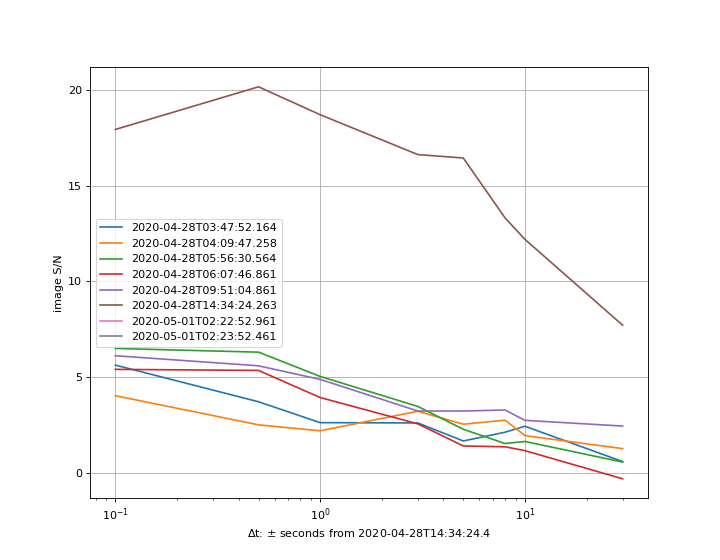

0.1 ['SGR 1935+2154'] [5.629776]
0.5 ['SGR 1935+2154'] [3.7182117]
1 ['SGR 1935+2154'] [2.6283221]
3 ['SGR 1935+2154'] [2.6125054]
5 ['SGR 1935+2154'] [1.6719856]
8 ['SGR 1935+2154'] [2.129828]
10 ['SGR 1935+2154'] [2.4396436]
30 ['SGR 1935+2154'] [0.59771353]
0.1 ['SGR 1935+2154'] [4.0335217]
0.5 ['SGR 1935+2154'] [2.5143385]
1 ['SGR 1935+2154'] [2.2032754]
3 ['SGR 1935+2154'] [3.2223177]
5 ['SGR 1935+2154'] [2.546918]
8 ['SGR 1935+2154'] [2.7578068]
10 ['SGR 1935+2154'] [1.9522648]
30 ['SGR 1935+2154'] [1.272452]
0.1 ['SGR 1935+2154'] [6.5002975]
0.5 ['SGR 1935+2154'] [6.3072414]
1 ['SGR 1935+2154'] [5.0410767]
3 ['SGR 1935+2154'] [3.4745505]
5 ['SGR 1935+2154'] [2.2821083]
8 ['SGR 1935+2154'] [1.5387497]
10 ['SGR 1935+2154'] [1.6455008]
30 ['SGR 1935+2154'] [0.5708029]
0.1 ['SGR 1935+2154'] [5.4086113]
0.5 ['SGR 1935+2154'] [5.353695]
1 ['SGR 1935+2154'] [3.9391627]
3 ['SGR 1935+2154'] [2.56295]
5 ['SGR 1935+2154'] [1.4126585]
8 ['SGR 1935+2154'] [1.3676342]
10 ['SGR 1935+2154'] [1.

In [256]:

plt.figure(figsize=(9,7))

plt.grid()


for burst in bursts:
    rs = burst['image_results']
    
    image_snr_by_dt_scale = {}
    
    
    for dt, r in rs.items():
        skyres = fits.open(r.skyres)[2]
        d=skyres.data
        #m = d['DETSIG']>0
        m = d['NAME'] == 'SGR 1935+2154'
        print(dt, d['NAME'][m], d['DETSIG'][m])

        if sum(m) != 0:
            image_snr_by_dt_scale[dt] = d['DETSIG'][m][0]
    
    plt.plot(
        np.array(list(image_snr_by_dt_scale.keys())),
        np.array(list(image_snr_by_dt_scale.values())),
        label=burst['utc']
    )
    
    if len(image_snr_by_dt_scale)==0:
        print("does not qualify")
        burst['image_confirmed'] = False
    else:
        burst['image_confirmed'] = True
        burst['image_snr_by_dt_scale']  = image_snr_by_dt_scale
        burst['best_image_time_scale'] = max(image_snr_by_dt_scale.items(), key=lambda x:x[1])


plt.xlabel("$\Delta$t: $\pm$ seconds from {}".format(burst_0_utc))
plt.ylabel("image S/N")
plt.legend()

plt.semilogx()

#!mkdir -pv draft/PAPER_SGR1935_INTEGRAL/fig/diagnostic
plt.savefig("draft/PAPER_SGR1935_INTEGRAL/fig/diagnostic/SN_vs_timescale_multiburst.pdf")


In [166]:
from collections import defaultdict
import glob
from astropy.wcs import WCS


<IPython.core.display.Javascript object>


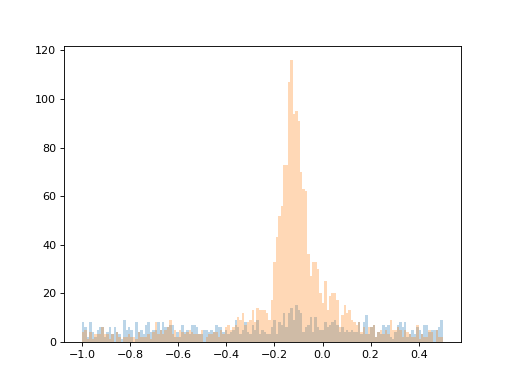

In [292]:
f=fits.open("/mnt/sshfs/isdc-in01//unsaved_data/savchenk/data/reduced/ddcache//byscw/2222/222200240010.000/evts_extract.v0/81903a67//source_evts.fits.gz")
evts = f[2].data

t_rel_s = (evts['TIME'] - burst_0_ijd)*24*3600
pif = evts['PIF_1']

plt.figure()

pif_thr = 0.3

h=plt.hist(
    t_rel_s[pif<=pif_thr], 
    np.linspace(-1,0.5, int(1.5*100)),
    alpha=0.3
)


h=plt.hist(
    t_rel_s[pif>pif_thr], 
    bins=h[1],
    alpha=0.3
)





2020-05-03T23:25:13.262
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-03T23:25:13.262/ANY


<IPython.core.display.Javascript object>


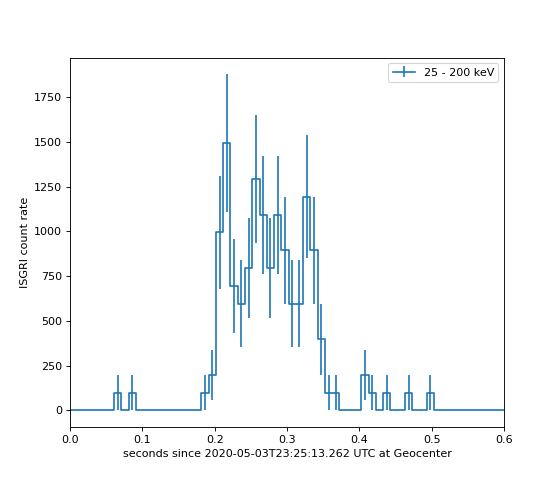

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less


events in selection 194


In [315]:
import re



def plot_one(t_refplot_utc):
    print(t_refplot_utc)
    sc = ic.get_sc(t_refplot_utc, ra=source_coord.ra.deg, dec=source_coord.dec.deg)
    dt_intgeo = sc['barytime']
    sc

    tc = ic.converttime("UTC", t_refplot_utc, "ANY")
    scwid = tc['SCWID']

    t_refplot_ijd = float(tc['IJD'])

    i_evts=fits.open("/mnt/sshfs/isdc-in01//unsaved_data/neronov/data/reduced/ddcache-private-staging-1.2//byscw/{}/{}.000/evts_extract.v0//06aef025/source_evts.fits.gz".format(scwid[:4], scwid))[2].data
    i_evts_en=i_evts

    ebands = [(25,200)]

    plt.figure(figsize=(7,6))

    rates={}

    bins = None

    tbin = 0.01

    for e1,e2 in ebands:
        m = i_evts_en['ENERGY']>=e1
        m &= i_evts_en['ENERGY']<e2

        t_plot_s = (i_evts['TIME'] + dt_intgeo/24/3600 -t_refplot_ijd)*24*3600

        m &= np.abs(t_plot_s)<2

        m &= i_evts['PIF_1']>0.3

        print("events in selection", sum(m))


        if bins is None:
            _ts = t_plot_s[m]
            bins=np.linspace(_ts.min(), _ts.max(), int((_ts.max()-_ts.min())/tbin))

        h = np.histogram(t_plot_s[m], bins=bins)

        if isinstance(bins, int):
            bins = h[1]

        tc = (h[1][1:] + h[1][:-1])*0.5
        dt = (h[1][1:] - h[1][:-1])
        rate = h[0]/dt
        rate_err = h[0]**0.5/dt

        rates[(e1,e2)] = dict(
            rate = rate,
            rate_err = rate_err,
            tc = tc,
            dt = dt,
        )

        if True:
            plt.errorbar(
                tc,
                rate,
                rate_err,
                ds="steps-mid",
                label="%.5lg - %.5lg keV"%(e1,e2),
            )
        else:
            plt.step(
                tc,
                rate,
                ds="steps-mid",
                label="%.5lg - %.5lg keV"%(e1,e2),
                alpha=0.5,
            )



    #plt.axvspan(
    #    (t_radio_p1_ijd - t_refplot_ijd)*24*3600 - radiotopo_s,
    #    (t_radio_p2_ijd - t_refplot_ijd)*24*3600 + radiotopo_s,
    #    alpha=0.2,
    #)

    #plt.axvline(
    #    (t_radio_detinf_ijd - t_refplot_ijd)*24*3600,
    #    alpha=0.5,
    #    label="radio ref",
    #    lw=2,
    #)


    #plt.axvline(
    #    (t_radio_p1_ijd - t_refplot_ijd)*24*3600,
    #    alpha=0.2,
    #    label="radio 1",
    #)


    #print("dt:")



    plt.xlim([-0, 0.6])
    #plt.xlim([.40, 0.55])
    plt.ylabel("ISGRI count rate")
    plt.xlabel("seconds since "+t_refplot_utc+" UTC at Geocenter")

    plt.legend()

    fn = "draft/PAPER_SGR1935_INTEGRAL/data/burst-search/burst-plots/lc_peakandspec_{}.pdf".format(re.sub("[:]", "-", t_refplot_utc))
    plt.savefig(fn)
    plt.savefig(fn.replace(".pdf", ".png"))
    

    plt.show()
    
plot_one("2020-05-03T23:25:13.262")

In [ ]:
for burst in bursts:
    burst[]

In [333]:
#yaml.dump(_bursts, open("draft/PAPER_SGR1935_INTEGRAL/data/burst-search/bursts.yaml", "w"))